In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils
from PIL import Image

import lightning as L
from torch.utils.data import random_split, Dataset, DataLoader

# Create train.csv

In [29]:
res = []
for file in os.listdir("./BrainTumorDataset/train/imagesTrain"):
    # print(file)
    res.append(file)
res = sorted(res)[2:]
res

df1 = pd.DataFrame(res)
df2 = pd.DataFrame(np.repeat(df1.values, 151, axis=0))
df2.to_csv('list.csv')

In [ ]:
base = []
for path, subdirs, files, in os.walk("./BrainTumorDataset/train/imagesTrain"):
    for name in files:
        base.append(os.path.join(path, name))
base = sorted(base)[2:]
# base

df = pd.DataFrame(base)
df.to_csv("train_image_list")

In [36]:
x1_filter = [name for name in base if 'x1' in name]
x2_filter = [name for name in base if 'x2' in name]
x3_filter = [name for name in base if 'x3' in name]
x4_filter = [name for name in base if 'x4' in name]

In [37]:
base_mask  = []
for path, subdirs, files, in os.walk("./BrainTumorDataset/train/labelsTrain"):
    for name in files:
        base_mask.append(os.path.join(path, name))
base_mask = sorted(base_mask)[2:]
base_mask

['./BrainTumorDataset/train/labelsTrain/BRATS_002/BRATS_002_z001.png',
 './BrainTumorDataset/train/labelsTrain/BRATS_002/BRATS_002_z002.png',
 './BrainTumorDataset/train/labelsTrain/BRATS_002/BRATS_002_z003.png',
 './BrainTumorDataset/train/labelsTrain/BRATS_002/BRATS_002_z004.png',
 './BrainTumorDataset/train/labelsTrain/BRATS_002/BRATS_002_z005.png',
 './BrainTumorDataset/train/labelsTrain/BRATS_002/BRATS_002_z006.png',
 './BrainTumorDataset/train/labelsTrain/BRATS_002/BRATS_002_z007.png',
 './BrainTumorDataset/train/labelsTrain/BRATS_002/BRATS_002_z008.png',
 './BrainTumorDataset/train/labelsTrain/BRATS_002/BRATS_002_z009.png',
 './BrainTumorDataset/train/labelsTrain/BRATS_002/BRATS_002_z010.png',
 './BrainTumorDataset/train/labelsTrain/BRATS_002/BRATS_002_z011.png',
 './BrainTumorDataset/train/labelsTrain/BRATS_002/BRATS_002_z012.png',
 './BrainTumorDataset/train/labelsTrain/BRATS_002/BRATS_002_z013.png',
 './BrainTumorDataset/train/labelsTrain/BRATS_002/BRATS_002_z014.png',
 './Br

In [38]:
train_df = pd.DataFrame({
    'mode_0': x1_filter,
    'mode_1': x2_filter,
    'mode_2': x3_filter,
    'mode_3': x4_filter,
    'mask': base_mask
})
train_df.to_csv("train.csv")

# Further down

In [2]:
class BrainTumorDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.csv = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_0 = np.array(Image.open(self.csv.loc[idx]["mode_0"]).convert("L"), dtype=np.float32)
        image_1 = np.array(Image.open(self.csv.loc[idx]["mode_1"]).convert("L"), dtype=np.float32)
        image_2 = np.array(Image.open(self.csv.loc[idx]["mode_2"]).convert("L"), dtype=np.float32)
        image_3 = np.array(Image.open(self.csv.loc[idx]["mode_3"]).convert("L"), dtype=np.float32)
        
        image = np.stack((image_0, image_1, image_2, image_3), axis=2)
        mask = np.array(Image.open(self.csv.loc[idx]["mask"]).convert("L"), dtype=np.float32)

        
        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

# Non-Lightning code

In [3]:
train_dataset = BrainTumorDataset(csv_file="train.csv")
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [5]:
train_dataset[100][0].shape

(240, 240, 4)

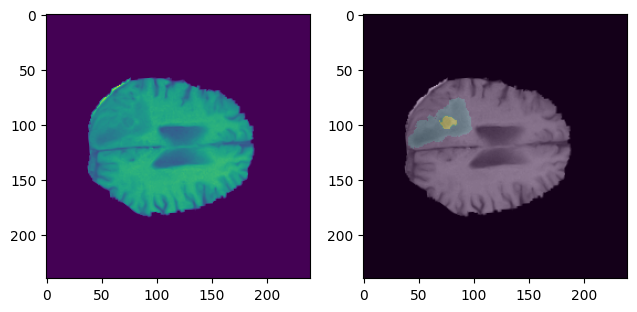

In [6]:
_, figure = plt.subplots(1, 2, figsize=(7.5, 15))

figure[0].imshow(train_dataset[100][0][:,:,1])
figure[1].imshow(train_dataset[100][0][:,:,1], 'gray', interpolation=None)
figure[1].imshow(train_dataset[100][1], interpolation=None, alpha=0.3)
plt.show()

# Lightning code

In [3]:
class BrainTumorDataModule(L.LightningDataModule):
    def __init__(self, data_dir: str = "./"):
        super().__init__()
        self.data_dir = data_dir
        self.transform = transforms.Compose([transforms.ToTensor()])

    def prepare_data(self):
        pass

    def setup(self, stage: str):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit":
            full = BrainTumorDataset(csv_file="train.csv")
            self.train, self.val = random_split(
                full, [0.9, 0.1], generator=torch.Generator().manual_seed(42)
            )

        # Assign test dataset for use in dataloader(s)
        if stage == "test":
            self.test = BrainTumorDataset(csv_file="train.csv")

        # if stage == "predict":
        #     self.mnist_predict = BrainTumorDataset(csv_file="train.csv")

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=32, num_workers=11)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=32, num_workers=11)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=32, num_workers=11)

    # def predict_dataloader(self):
    #     return DataLoader(self.mnist_predict, batch_size=32)
    

In [4]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

weights = FCN_ResNet50_Weights.DEFAULT
# transforms = weights.transforms(resize_size=None)

model = fcn_resnet50(num_classes=3)

class LitFCN(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def training_step(self, batch, batch_idx):
        x, y = batch
        # print(y.type())
        y_hat = self.model(x.float().permute(0, 3, 1, 2))['out']
        
        y = y.long()
        # print(x.get_device(), y.get_device(), y_hat.get_device())
        # print(y_hat.type())
        loss_fn = torch.nn.CrossEntropyLoss()
        loss = loss_fn(y_hat, y)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1)
        return [optimizer], [lr_scheduler]

In [5]:
model.backbone.conv1 = torch.nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [6]:
model

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [7]:
dm = BrainTumorDataModule()

In [8]:
trainer = L.Trainer()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
mod = LitFCN(model)
trainer.fit(mod, datamodule=dm)

/home/tanyapruek/miniconda3/envs/deeplearning/lib/python3.10/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
/home/tanyapruek/miniconda3/envs/deeplearning/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 4080 SUPER') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | FCN  | 33.0 M
-------------------------------
33.0 M    Trainable params
0     

Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/conda-bld/pytorch_1704987280714/work/aten/src/ATen/native/cuda/NLLLoss2d.cu:104: nll_loss2d_forward_kernel: block: [2,0,0], thread: [384,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1704987280714/work/aten/src/ATen/native/cuda/NLLLoss2d.cu:104: nll_loss2d_forward_kernel: block: [2,0,0], thread: [385,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1704987280714/work/aten/src/ATen/native/cuda/NLLLoss2d.cu:104: nll_loss2d_forward_kernel: block: [2,0,0], thread: [386,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1704987280714/work/aten/src/ATen/native/cuda/NLLLoss2d.cu:104: nll_loss2d_forward_kernel: block: [2,0,0], thread: [387,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1704987280714/work/aten/src/ATen/native/cuda/NLLLoss2d.cu:104: nll_loss2d_forward_kernel: block: [2,0,0], thread: [388,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/cond

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
